# ΜΑΡΙΑ ΚΑΙΚΤΖΟΓΛΟΥ - 03400052
# ΔΗΜΗΤΡΗΣ ΖΕΡΚΕΛΙΔΗΣ - 03400049

## ΒΗΜΑ 18 BI-LSTM

Παρακάτω είναι η συνάρτηση parser , για να διαβάζουμε τα αρχεία ήχου.

In [8]:
import numpy as np
import librosa
from glob import glob
import os
import torch
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
import sys
import matplotlib.pyplot as plt

def parser(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, '*.wav'))
    fnames = [f.split('/')[-1].split('.')[0].split('_') for f in files]
    ids = [f[2] for f in fnames]
    #print(ids)
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        global Fs
        wav, fs = librosa.core.load(f, sr=None)
        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [librosa.feature.mfcc(wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=6).T for wav in wavs]
    # Print dataset info
    #print('Total wavs: {}'.format(len(frames)))

    # Standardize data
    scaler = StandardScaler()
    scaler.fit(np.concatenate(frames))
    for i in range(len(frames)):
        frames[i] = scaler.transform(frames[i])

    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ['0', '1', '2', '3', '4']
    for idx, frame, label, spk in zip(ids, frames, y, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test



from sklearn.model_selection import train_test_split
directory = "../recordings/"
X_train, X_test, y_train, y_test, spk_train, spk_test = parser(directory)


Αυτή είναι η συνάρτηση που μας δίνεται για να κάνουμε plot τα confusion matrix.

In [9]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm , classes=[0,1,2,3,4,5,6,7,8,9],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Μετατρέπουμε σε torch tensors τα training δεδομένα μας, ενώ στη συνέχεια κάνουμε padding ώστε να έχουν όλα το ίδιο μέγεθος. Τα δεδομένα θα έχουν το μέγεθος της μεγαλύτερης ακολουθίας χρόνου.

Τα δεδομένα εισόδου π.χ. X_train είναι της μορφής "number-of-samples X max_timestep_with_padding X # of MFCCs"

In [3]:
for i in range(len(X_train)):
    X_train[i] = torch.from_numpy(X_train[i])
X_train = torch.nn.utils.rnn.pad_sequence(X_train, batch_first=True)

Χωρίζουμε τα δεδομένα training σε training και validation, με σκοπό να γνωρίζουμε πότε το μοντέλο γίνεται overfit και κάνει fit τον θόρυβο. Επίσης, σπάμε τα δεδομένα σε batch_size = 64.

Tέλος, φτιάχνουμε ένα dictionary το οποίο θα μας δείχνει πότε να χρησιμοποιούμε τα training δεδομένα και πότε τα validation ώστε να τα προβλέπουμε και σύμφωνα με το ποσοστό επιτυχίας να βλέπουμε αν το μοντέλο μας παρουσιάζει overfitting.

In [4]:
X_train, X_val, y_train, y_val=train_test_split(X_train.numpy(), y_train, test_size=0.2, random_state=1, stratify = y_train)
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train),torch.from_numpy(np.asarray(y_train)))
val_data = torch.utils.data.TensorDataset(torch.from_numpy(X_val),torch.from_numpy(np.asarray(y_val)))
train_loader = torch.utils.data.DataLoader(train_data,batch_size = 64, shuffle = True)
valid_loader = torch.utils.data.DataLoader(val_data)
dataloaders = {'train':train_loader,'val':valid_loader}

Παρακάτω δημιουργούμε ένα Bidirectional LSTM , το οποίο δέχεται ακολουθίες μεγέθους 6 , επειδή κάθε sample έχει 6 MFCCs. Επίσης, έχει hidden layer size 256 και αριθμό LSTM layer ίσο με 1.

Χρησιμοποιούμε Dropout στο 30%. To dropout βοηθάει,ώστε το μοντέλο μας να μη γίνει overfit. Αυτό το κάνει, σβήνοντας κάποιους κόμβους από το hidden layer με πιθανότητα 30%. Επομένως, αναγκάζει κόμβους οι οποίοι έχουν γίνει overtrained να είναι σα να μην υπάρχουν, ώστε να εκπαιδευτούν και οι άλλοι κόμβοι. Αυτό έχει ως αποτέλεσμα να είναι όλοι οι κόμβοι να έχουν γίνει trained όμοια, χωρίς κάποιος να χει γίνει παραπάνω.

Στο output layer έχουμε 10 outputs, 1 για κάθε κλάση. Δεν υπολογίζουμε κάποια πιθανότητα εδώ , καθώς το pytorch το κάνει από μόνο του με την CrossEntropy συνάρτηση.


In [5]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class LSTMClassifier(nn.Module):

    def __init__(self, ):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(6, 256, num_layers=1,batch_first =True , bidirectional = True)
        self.hidden2out = nn.Linear(256,10)
        self.dropout_layer = nn.Dropout(p=0.3)
    def forward(self, data):
        outputs, (ht, ct) = self.lstm(data, None) 
        output = self.dropout_layer(ht[-1])
        output = self.hidden2out(output)
        return output
    

### Τι αλλάζει εσωτερικά σε ένα LSTM  όταν είναι bidirectional...

Αρχικά, έχουμε επιλέξει να κάνουμε ένα bidirectional LSTM το οποίο υλοποιείται με την παράμετρο bidirectional = True όπως φαίνεται παραπάνω.

Αυτό αλλάζει την εσωτερική λειτουργία με τον εξής τρόπο. Πλέον διατρέχουμε μια ακολουθία όχι μόνο left->right αλλά και right->left επομένως τα hidden states έχουν διπλάσιο μέγεθος καθώς τα μισά είναι λόγω της left to right διαδικασίας ενώ τα άλλα μισά είναι λόγω της right to left διαδικασίας.

Συνήθως, παίρνουμε το τελευταίο hidden unit από τα 2 παραπάνω είδη hidden states που έχουμε το οποίο και έχει συσσωρεύσει όλη την πληροφορία για την δοσμένη ακολουθία και τα κάνουμε concatenate και στη συνέχεια υπάρχουν διάφορες εφαρμογές που μπορούν να υλοποιηθούν.

Με τα bi-lstm μπορούμε να πιάσουμε συσχετίσεις που με τα μονά lstm δε μπορούσαμε λόγω του ότι κοιτάμαι την ακολουθία και ανάποδα.

### Έλεγχος αν υπάρχει cuda στο υπολογιστικό σύστημα.

In [6]:
if(torch.cuda.is_available()):
  device = 'cuda'
else:
  device = 'cpu'
model = LSTMClassifier().to(device)

### Υλοποίηση early stopping

Αυτή η συνάρτηση χρησιμοποιείται,ώστε να σταματήσουμε να εκπαιδεόυμε το μοντέλο πριν τελείωσουν τα epochs που έχουμε βάλει.

Αυτό μας βοηθάει στην αποφυγή του overfitting καθώς βλέπουμε αν το score στο validation set είναι καλύτερο για έναν αριθμό π.χ. Patience=3, δηλαδή 3 φορές συνεχόμενα το σκορ στο validation set πέφτει , τότε σημαίνει πως έχουμε overfit και πρέπει να σταματήσουμε την εκπαίδευση καθώς πλέον σταματάει να γενικοποιείται και μοντελοποιεί τον θόρυβο.Έτσι, αποθηκεύσουμε το καλύτερο μοντέλο που είναι αυτό που είχε το καλύτερο σκορ πριν τις 3 τελευταίες πτώσεις.

Για την αποθήκευση του μοντέλου δε χρησιμοποιούμε το module pickle όπως στα GMM-HMM , αλλά τη συνάρτηση του pytorch torch.save() και αποθηκεύουμε το καλύτερο μοντέλο σε ένα αρχείο checkpoint.pt



In [10]:
import numpy as np
import torch
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

Παρακάτω είναι η συνάρτηση train , η οποία έχει μεταβλητό αριθμό εποχών που τρέχει, επίσης δέχεται ένα optimizer ανάλογα τη συνάρτηση για το backward propagation. Επίσης δηλώνουμε το Patience, δηλαδή πόσες φορές πρέπει να μειωθεί συνεχόμενα το accuracy του validation set ώστε να σταματήσουμε την εκπαίδευση νωρίς.

Όπως φαίνεται παρακάτω για κάθε εποχή τρέχουμε 1 φορά το training και μετά το validation dataset. Έτσι σε κάθε epoch έχουμε μια αποτίμηση του μοντέλου μας.

Κάθε φορά τυπώνουμε τα ποσοστά του training και validation , ενώ στο τέλος δημιουργούμε και ένα διάγραμμα Validation - Training Loss over the number of epochs.

In [10]:
def train(model,dataloaders,num_epochs,optimizer,patience):
    Flag=False
    # for loss
    val_loss = []
    train_loss = []
    phase1 = dataloaders.keys()
    criterion = nn.CrossEntropyLoss()
    train_loader = dataloaders['train']
    if(torch.cuda.is_available()):
        device = 'cuda'
    else:
        device = 'cpu'
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)
    for epoch in range(num_epochs):
        counter = epoch
        if Flag == True:
            break
        print('Epoch:',epoch + 1)
        epoch_metrics = {"loss": [], "acc": []}
        for phase in phase1:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.FloatTensor).to(device)
                target = target.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                output = model(data) 
                loss = criterion(output, target)
                acc = 100 * (output.detach().argmax(1) == target).cpu().numpy().mean()
                epoch_metrics["loss"].append(loss.item())
                epoch_metrics["acc"].append(acc)
                sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                % (
                    epoch + 1,
                    num_epochs,
                    batch_idx,
                    len(dataloaders[phase]),
                    loss.item(),
                    np.mean(epoch_metrics["loss"]),
                    acc,
                    np.mean(epoch_metrics["acc"]),
                    )
                )

                if(phase =='train'):
                    loss.backward()
                    optimizer.step()
            
            epoch_acc = np.mean(epoch_metrics["acc"])
            epoch_loss = np.mean(epoch_metrics["loss"])
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else: 
                val_loss.append(epoch_loss)
            if(phase == 'val' and patience !=None):
                earlystop(epoch_loss,model)
                if(earlystop.early_stop):
                    print("Early stopping")
                    model.load_state_dict(torch.load('./checkpoint.pt'))
                    print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
                    #break
                    Flag = True
        print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
    epochs_axis = np.arange(counter)
    plt.plot(epochs_axis, train_loss,color='red')
    plt.plot(epochs_axis, val_loss,color='blue')
    plt.legend(['training-red', 'validation-blue'], loc='upper left')
    plt.show()


### ΥΛΟΠΟΙΗΣΗ L2 REGULARIZATION

Η παράμετρος weight_decay ουσιαστικά ενεργοποιεί το l2 regularization. To l2 regularization είναι ένας τρόπος να <<τιμωρήσουμε>> τις μεγάλες τιμές των weights ώστε να αποφύγουμε το overfitting προσθέτοντας το τετράγωνο της νόρμας των βαρών στη συνάρτηση loss.

Με αυτόν τον τρόπο είναι σα να λέμε στα weights μας να μη μεγαλώσουν πολύ και να προτιμήσουν ένα αρκετά πιο απλό μοντέλο.

Epoch: 1
[Epoch 1/20] [Batch 269/270] [Loss: 1.364512 (1.753237), Acc: 100.00% (49.17%)]Validation loss decreased (inf --> 1.753237).  Saving model ...
val Accuracy: 49.17169611747138
Epoch: 2
[Epoch 2/20] [Batch 269/270] [Loss: 1.696128 (1.267725), Acc: 0.00% (58.72%)]Validation loss decreased (1.753237 --> 1.267725).  Saving model ...
val Accuracy: 58.71857889497263
Epoch: 3
[Epoch 3/20] [Batch 269/270] [Loss: 1.163006 (0.925877), Acc: 0.00% (69.61%)]Validation loss decreased (1.267725 --> 0.925877).  Saving model ...
val Accuracy: 69.60708063713291
Epoch: 4
[Epoch 4/20] [Batch 269/270] [Loss: 0.736272 (0.634622), Acc: 100.00% (83.28%)]Validation loss decreased (0.925877 --> 0.634622).  Saving model ...
val Accuracy: 83.27603907416625
Epoch: 5
[Epoch 5/20] [Batch 269/270] [Loss: 0.230565 (0.535321), Acc: 100.00% (82.71%)]Validation loss decreased (0.634622 --> 0.535321).  Saving model ...
val Accuracy: 82.70828148332504
Epoch: 6
[Epoch 6/20] [Batch 269/270] [Loss: 0.071535 (0.458924)

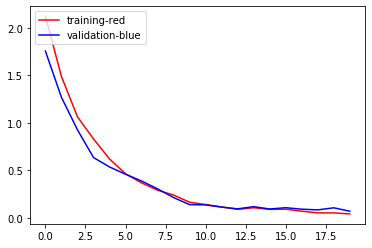

In [11]:
optim = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay = 1e-3) # weight decay is for l2 regularization
train(model,dataloaders,20,optim,3)

Το διάγραμμα δείχνει πως είχαμε μείωση και του validation και του training set καθ'όλη τη διάρκεια. Κάποιες φορές ο μετρητής early stopping ξεκίναγε να μετράει όταν μειωνόταν το validation score όπως στις εποχές 14,16,19 αλλά μετά ξανά βελτιωνόταν το accuracy οπότε δε χρειάστηκε να σταματήσουμε το μοντέλο μας.

### Test set evaluation

Παρακάτω κάνουμε predict τα test δεδομένα και δίνουμε το ποσοστό επιτυχίας και το confusion matrix. 

In [13]:
for i in range(len(X_test)):
    X_test[i] = torch.from_numpy(X_test[i])
X_test = torch.nn.utils.rnn.pad_sequence(X_test, batch_first=True)

In [14]:
test_data = torch.utils.data.TensorDataset(X_test,torch.from_numpy(np.asarray(y_test)))
test_loader = torch.utils.data.DataLoader(test_data ,batch_size = 1, shuffle = True)

In [15]:
model = LSTMClassifier()
model.load_state_dict(torch.load('./checkpoint.pt'))
model.eval()

LSTMClassifier(
  (lstm): LSTM(6, 256, batch_first=True, bidirectional=True)
  (hidden2out): Linear(in_features=256, out_features=10, bias=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
)

In [16]:
acc = 0 
total = 0

y_test_for_cm = []
y_test_predict_cm = []
with torch.no_grad():
    for  batch_idx , (data, target) in enumerate(test_loader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.FloatTensor).to(device)
        target = target.type(torch.LongTensor).to(device)
        output = model(data).detach().argmax(1)
        
        y_test_for_cm.append(target)
        y_test_predict_cm.append(output)
        if output == target:
            acc += 1
        total +=1
score = (acc/total) *100

cm_test = confusion_matrix(y_test_for_cm ,y_test_predict_cm )
print("test set accuracy equals to {} ".format(score))

test set accuracy equals to 99.33333333333333 


### Confusion Matrix for Test set

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.93333333 0.         0.         0.06666667 0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.     

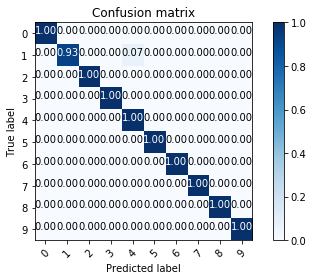

In [17]:
plot_confusion_matrix(cm_test,normalize=True)

### Confusion Matrix for val set + evaluation again

In [18]:
acc = 0 
total = 0

y_val_for_cm = []
y_val_predict_cm = []
with torch.no_grad():
    for  batch_idx , (data, target) in enumerate(valid_loader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.FloatTensor).to(device)
        target = target.type(torch.LongTensor).to(device)
        output = model(data).detach().argmax(1)
        
        y_val_for_cm.append(target)
        y_val_predict_cm.append(output)
        if output == target:
            acc += 1
        total +=1
score = (acc/total) *100

cm_val = confusion_matrix(y_val_for_cm ,y_val_predict_cm )
print("val set accuracy equals to {} ".format(score))

val set accuracy equals to 98.14814814814815 


Normalized confusion matrix
[[0.96296296 0.         0.         0.03703704 0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.96296296
  0.         0.03703704 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.96296296 0.         0.03703704 0.        ]
 [0.         0.         0.         0.03703704 0.         0.
  0.         0.96296296 0.         0.        ]
 [0.         0.         0.         0.03703704 0.         0.
  0.         0.         0.96296296 0.        ]
 

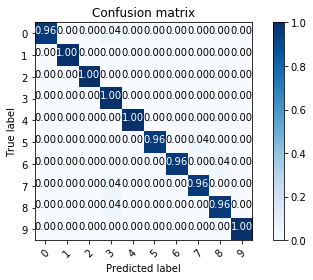

In [19]:
plot_confusion_matrix(cm_val,normalize=True)

## PACKED PAD SEQUENCES ~ TESTING THE DIFFERENCE IN SPEED

## δείτε το lstm_packed.ipynb